# Do aggressive gas bids in Ethereum's mempool predict next-minute ETH volatility?

- Description: Collected total queued transaction, average gas price, top 10% gas price from Ethereum Mempool data (flasbot mempool dumpster) and ETH/USD price.
- H0: A spike in p90_gas_price_gwei is independent to realised ETH volatility in the next 5 minutes.
- H1: A spike in p90_gas_price_gwei predicts increase in realised ETH volatility in the next 5 minutes.

In [196]:
from dune_client.client import DuneClient
import pandas as pd, json, pathlib
from dotenv import load_dotenv
import os 
import numpy as np
import matplotlib.pyplot as plt

## Store Data from Dune Analytics Using REST API

In [197]:
# load_dotenv()
# api_key = os.getenv("DUNE_API_KEY")
# QUERY_ID = os.getenv("DUNE_QUERY_ID")
# client  = DuneClient(api_key)
# result  = client.get_latest_result(QUERY_ID)
# df_raw = pd.DataFrame(result.get_rows())
# pathlib.Path("cache").mkdir(exist_ok=True)
# df_raw.to_parquet("cache/mempool_raw.parquet")

## Build research features

In [198]:
df = pd.read_parquet('cache/mempool_raw.parquet')

In [199]:
df['min']           = pd.to_datetime(df['min'], errors='coerce')
df['price_ret_1m']  = np.log(df['eth_price_usd']).diff()
df['real_vol_5m']   = df['price_ret_1m'].abs().rolling(5).mean().shift(-5)  
df['gas_z']         = (df['p90_gas_price_gwei'] - df['p90_gas_price_gwei'].rolling(60).mean()) / df['p90_gas_price_gwei'].rolling(60).std()
df['queued_z']      = (df['queued_tx'] - df['queued_tx'].rolling(60).mean()) / df['queued_tx'].rolling(60).std()
df = df.dropna()
df.info(); df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1643 entries, 59 to 1701
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   avg_gas_price_gwei  1643 non-null   float64            
 1   eth_price_usd       1643 non-null   float64            
 2   min                 1643 non-null   datetime64[ns, UTC]
 3   p90_gas_price_gwei  1643 non-null   float64            
 4   queued_tx           1643 non-null   int64              
 5   total_gas_units     1643 non-null   int64              
 6   price_ret_1m        1643 non-null   float64            
 7   real_vol_5m         1643 non-null   float64            
 8   gas_z               1643 non-null   float64            
 9   queued_z            1643 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(2)
memory usage: 141.2 KB


,avg_gas_price_gwei,eth_price_usd,p90_gas_price_gwei,queued_tx,total_gas_units,price_ret_1m,real_vol_5m,gas_z,queued_z
count,1643.000000,1643.000000,1643.000000,1643.000000,1.643000e+03,1643.000000,1643.000000,1643.000000,1643.000000
mean,35.694747,2714.503165,70.769389,1336.429093,5.828538e+08,0.000051,0.000281,-0.032133,-0.085774
std,20.081118,48.941777,38.729885,855.669221,5.292591e+09,0.000911,0.000296,1.051053,1.058178
min,9.606693,2583.100000,4.894648,446.000000,6.173136e+07,-0.010935,0.000000,-4.932298,-5.234887
25%,25.553185,2679.830000,47.330237,642.000000,1.172573e+08,0.000000,0.000090,-0.690738,-0.643539
50%,36.504405,2704.530000,78.880472,812.000000,1.745821e+08,0.000000,0.000201,-0.122812,-0.205068
75%,44.125431,2754.330000,88.742551,2047.000000,2.568463e+08,0.000000,0.000368,0.563448,0.275626
max,679.060621,2816.550000,540.585963,14361.000000,1.817796e+11,0.011775,0.002355,7.546078,7.564404


## Build and Analyse HAC-robust OLS for Gas Urgency vs Next 5 min vol

- R-squared = 0.001: Gas z-score explains 0.1% of the variation in 5-min volatility; model has no explanatory power
- Durbin-Watson = 0.3: Residuals are strongly autocorrelated; require data-preprocessing
- Skew = 2.8, Kurtosis = 15.9, Heavy-tailed, right-skewed volatility distribution, which a OLS model is probabily ill-suited; require data-preprocessing

In [200]:
import statsmodels.api as sm
X = sm.add_constant(df['gas_z'])
y = df['real_vol_5m']

ols_model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':10})
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            real_vol_5m   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.8621
Date:                Wed, 11 Jun 2025   Prob (F-statistic):              0.353
Time:                        22:58:47   Log-Likelihood:                 11022.
No. Observations:                1643   AIC:                        -2.204e+04
Df Residuals:                    1641   BIC:                        -2.203e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   1.77e-05     15.944      0.0

## Plot

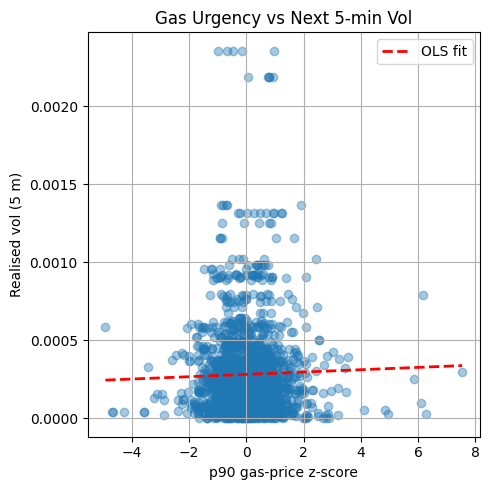

In [201]:
plt.figure(figsize=(5, 5))
plt.scatter(df["gas_z"], df["real_vol_5m"], alpha=0.4)
x_line = np.linspace(df['gas_z'].min(), df['gas_z'].max(), 100)
y_line = ols_model.params.iloc[0] + ols_model.params.iloc[1] * x_line
plt.plot(x_line, y_line, 'r--',lw=2, label='OLS fit')
plt.xlabel("p90 gas-price z-score")
plt.ylabel("Realised vol (5 m)")
plt.title("Gas Urgency vs Next 5-min Vol")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

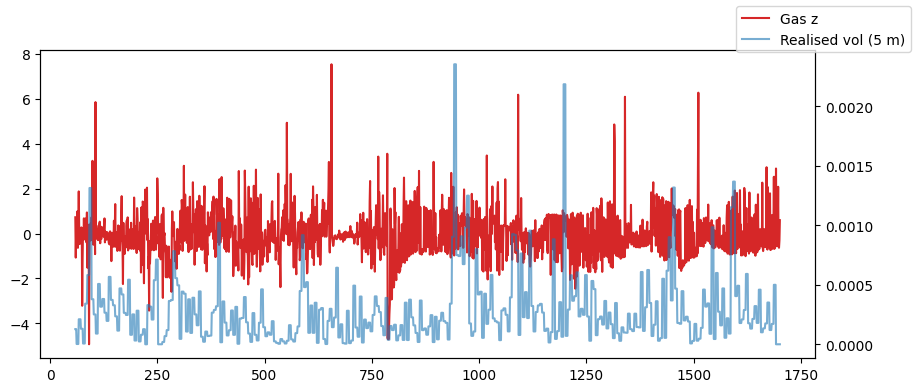

In [202]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df['gas_z'], label='Gas z', color='tab:red')
ax2 = ax1.twinx()
ax2.plot(df['real_vol_5m'], label='Realised vol (5 m)', color='tab:blue', alpha=0.6)
fig.legend(loc='upper right'); plt.show()

## Conclusion

- the gas-price z-score shows no measurable relationship to next-5-min ETH volatility. Under this specification, H1 is rejected.

## Future Work

- Add more historical data; Dune Analytics has fixed limit on number of data to fetch into the local server in free version account, so need alternative approach
- Explore various regresion models like multivariate AR / GARCH-X models to handle price and volume data
- Test other parameters including percentile, lags.
- Test other data-preprocessing methods